# K-Means

In recent years, data-driven approaches have become increasingly prevalent in various fields, enabling researchers to extract valuable insights and patterns from complex datasets. One such method, K-Means clustering, has proven to be a powerful technique for grouping similar data points together. In this study, we aim to apply K-Means clustering to the AIA171 dataset, a collection of solar images captured aboard NASA's Solar Dynamics Observatory (SDO). However, instead of directly using the image pixel values as feature vectors, we will convert the images into their 1D power spectrums and utilizing them as feature vectors. Moreover, we will employ Earth Movers Distance (EMD) as the measurement metric to compare the similarity between the power spectrum feature vectors. This combination of K-Means clustering, power spectrum conversion, and EMD holds great promise for revealing hidden patterns and structures within the solar images, ultimately enhancing our understanding of the Sun's surface.

## Import Libraries

In [2]:
# Import libraries
import glob
import sys
import os
import numpy as np
import PIL.Image as Image
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import distance_metric, type_metric
from pyclustering.cluster.center_initializer import random_center_initializer
import matplotlib.offsetbox as offsetbox

## Data Pre-Processing

### Converting a 2D image into its 1D Power Spectrum

Converting a 2D grayscaled image into its 1D power spectrum can be done as such:
1. Apply the 2D Fast Fourier Transform (FFT) to the image. This is done using the FFT method in the numpy library.
2. Once the FFT is applied, obtain the magnitude spectrum by taking the absolute value of the complex-valued result obtained from the FFT.
3. To convert the 2D power spectrum into 1D, average the magnitudes along concentric circles centered at the image's origin (zero frequency). This is done by calculating the average magnitude for each radius, starting from the center and moving outwards.
4. The resulting radial profile represents the 1D power spectrum, with the x-axis representing the radius and the y-axis representing the average magnitude or power at each radius.

The cell below is the method that follows the steps above to calulate the 1D power specturm

In [3]:
# Calculates 1d Power Spectrum
def power_spectrum_1d(image):

    # Get pixel count
    pixel_count = image.shape[0]

    # Convert into fourier transform
    fourier_image = np.fft.fftn(image)
    fourier_amplitudes = np.abs(fourier_image)

    #Calculate 1D power spectrum
    k_frequencies = np.fft.fftfreq(pixel_count) * pixel_count
    k_frequencies2D = np.meshgrid(k_frequencies, k_frequencies)
    k_norm = np.sqrt(k_frequencies2D[0] ** 2 + k_frequencies2D[1] ** 2)
    k_bins = np.arange(0.5, pixel_count // 2 + 1, 1.)
    k_vals = 0.5 * (k_bins[1:] + k_bins[:-1])
    a_bins, _, _ = stats.binned_statistic(k_norm.flatten(),
                                        (fourier_amplitudes ** 2).flatten(),
                                        statistic = "mean", bins = k_bins)
    a_bins *= np.pi * (k_bins[1:] ** 2 - k_bins[:-1] ** 2)
    
    return a_bins

# Calculates Wasserstein distance of two images
def wasserstein(x, y): 
    return stats.wasserstein_distance(np.arange(len(x)), np.arange(len(y)), x, y)

### Reading the Dataset
This cell creates two vectors: One to store the original image represented as a numpy array, and another to store the 1D power spectrum of the image

In [4]:
# Collect all images in AIA171_Miniset_BW and represent them as 1D power specturm numpy arrays
images = []
x = []
image_paths = glob.glob('./../../AIA171_Miniset_BW/**/*.jpg', recursive = True)
for image_path in image_paths:
    image = Image.open(image_path).convert('L')
    image = np.array(image)
    image = image.astype(float) / 255
    pow_spect = power_spectrum_1d(image)
    if pow_spect.any():
        images.append(image)
        x.append(pow_spect)
        
images = np.array(images)
x = np.array(x)   

### Dimensionality Reduction using t-SNE

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a dimensionality reduction technique commonly used for visualizing high-dimensional data in a lower-dimensional space. It aims to capture the underlying structure and relationships within the data by preserving the pairwise similarities between data points.

The cell below employs t-SNE using the scikit-learn method

In [5]:
embedded_x = TSNE().fit_transform(x)

n = np.max(embedded_x, axis=0)
m = np.min(embedded_x, axis=0)
embedded_x = (embedded_x - m) / (n - m)

## Data Clustering

### Visualising the Data

By replacing the data points in a scatterplot with actual images, you can create a more visually engaging and informative representation of the data. This also provides a good sense of what we may want our clusters to look like. The cell below creates a scatter plot that shows where a respective image is places based on their 1D power spectrum.

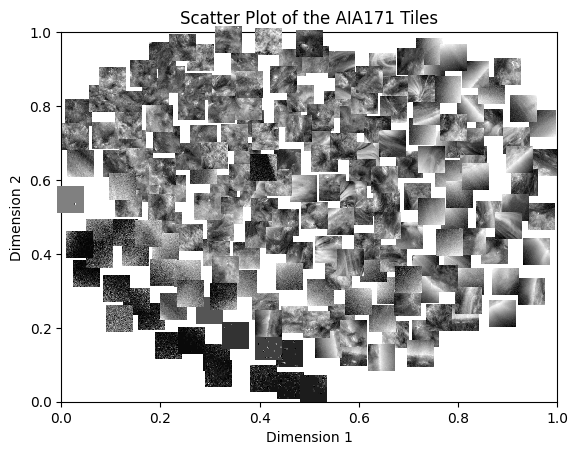

In [10]:
# shuffle images and find out which images to show
shown_images_idx = []
shown_images = np.array([[1.0, 1.0]])
iterator = [i for i in range(embedded_x.shape[0])]
np.random.shuffle(iterator)
for i in iterator:
    if len(shown_images_idx) >= 200:
        break
    # only show image if it is sufficiently far away from the others
    dist = np.sum((embedded_x[i] - shown_images) ** 2, 1)
    if np.min(dist) < 2e-3:
        continue
    
    shown_images = np.r_[shown_images, [embedded_x[i]]]
    shown_images_idx.append(i)

# Create the scatterplot
fig, ax = plt.subplots()

# Iterate over each data point and plot the image
for i in shown_images_idx:
    imagebox = offsetbox.OffsetImage(images[i], zoom=0.15, cmap='gray')
    imagebox.image.axes = ax
    ab = offsetbox.AnnotationBbox(imagebox, embedded_x[i], frameon=False)
    ax.add_artist(ab)

# Set the limits of the plot
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Show the scatterplot
plt.title('Scatter Plot of the AIA171 Tiles')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

### K-Means Clustering

Traditional K-Means clustering is a popular algorithm used for partitioning data into distinct groups based on their similarity. However, instead of using traditional distance metrics like Euclidean distance, you want to employ EMD as the measurement metric for K-Means clustering. To perform K-Means clustering, the following is done:

1. Choose the desired number of clusters (K) and randomly assign K initial cluster centroids.
2. For each data point, compute the EMD between the data point and each cluster centroid. Assign the data point to the cluster with the minimum EMD.
3. Recalculate the centroids of each cluster based on the assigned data points. The centroid is the center of mass of all the data points in that cluster.
4. Iterate steps 2 and 3 until convergence. Convergence occurs when the cluster assignments no longer change significantly or when a maximum number of iterations is reached.

The algorithm converges to a set of K cluster centroids and assigns each data point to one of the clusters based on the EMD. These clusters represent groups of data points that are most similar to each other according to the EMD metric. The cell below does the implementation of K-Means clustering with en EMD metric.

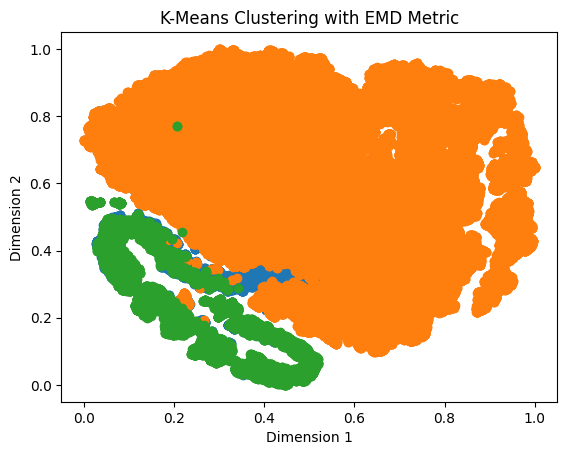

In [7]:
# Perform K-Means with pyclustering
initial_centers = random_center_initializer(x, 3).initialize()
model = kmeans(x, initial_centers = initial_centers, metric = distance_metric(type_metric.USER_DEFINED, func = wasserstein))
model.process()
clusters_idx = model.get_clusters()
centers = np.array(model.get_centers())

clusters = []
embedded_clusters = []
for cluster_idx in clusters_idx:
    cluster = np.array([x[i] for i in cluster_idx])
    clusters.append(cluster)

    embedded_cluster = np.array([embedded_x[i] for i in cluster_idx])
    embedded_clusters.append(embedded_cluster)


for embedded_cluster in embedded_clusters:
    plt.scatter(embedded_cluster[:,0], embedded_cluster[:,1])
plt.title('K-Means Clustering with EMD Metric')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()